## Battery Discharge Data Windowing Analysis
This notebook explores different windowing/paging strategies for battery discharge data
to prepare it for machine learning models for predictive maintenance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
import warnings
warnings.filterwarnings('ignore')

# Set up nice plotting defaults
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

### 1. Data Loading and Exploration
First, let's load a sample discharge file from our extracted data to understand its structure.

In [2]:
# Define paths
base_dir = "../../Only_Discharge_Dataset/"

# Find all discharge files for a specific battery
# We'll start with battery00 from regular_alt_batteries as an example
sample_battery_dir = os.path.join(base_dir, "regular_alt_batteries/battery01")

# List all discharge files for this battery
discharge_files = glob(os.path.join(sample_battery_dir, "discharge*.csv"))
print(f"Found {len(discharge_files)} discharge files in {sample_battery_dir}")

# Let's load one regular discharge and one reference discharge for comparison
regular_discharge_file = None
reference_discharge_file = None

for file in discharge_files:
    if "reference" in file:
        reference_discharge_file = file
    else:
        regular_discharge_file = file
    
    # Stop once we have one of each
    if regular_discharge_file and reference_discharge_file:
        break

# If we don't have both, use whatever we have
sample_file = regular_discharge_file or reference_discharge_file
print(f"Using sample file: {sample_file}")

# Load the sample discharge data
df = pd.read_csv(sample_file)

# Display basic information about the dataframe
print("\nDataset Overview:")
print(f"Shape: {df.shape}")
print("\nColumn names and types:")
print(df.dtypes)

print("\nFirst few rows:")
df.head()

Found 891 discharge files in ../../Only_Discharge_Dataset/regular_alt_batteries/battery01
Using sample file: ../../Only_Discharge_Dataset/regular_alt_batteries/battery01/discharge11.csv

Dataset Overview:
Shape: (960, 10)

Column names and types:
start_time               object
time                    float64
mode                    float64
voltage_charger         float64
temperature_battery     float64
voltage_load            float64
current_load            float64
temperature_mosfet      float64
temperature_resistor    float64
mission_type            float64
dtype: object

First few rows:


,start_time,time,mode,voltage_charger,temperature_battery,voltage_load,current_load,temperature_mosfet,temperature_resistor,mission_type
0,2022-08-14 19:41:00,116017.844,-1.0,8.373,25.303,-0.026,0.550298,28.06,29.90,1.0
1,2022-08-14 19:41:00,116018.828,-1.0,8.370,25.486,8.686,0.591305,27.94,29.83,1.0
2,2022-08-14 19:41:00,116019.798,-1.0,7.921,25.497,8.071,9.478416,27.82,29.77,1.0
3,2022-08-14 19:41:00,116020.769,-1.0,7.883,25.544,8.033,9.452606,27.75,29.70,1.0
4,2022-08-14 19:41:00,116021.740,-1.0,7.856,25.607,8.011,9.476140,27.72,29.63,1.0


## Let's explore the data in more detail to understand its characteristics.

Missing values per column:
No missing values

Basic statistics:


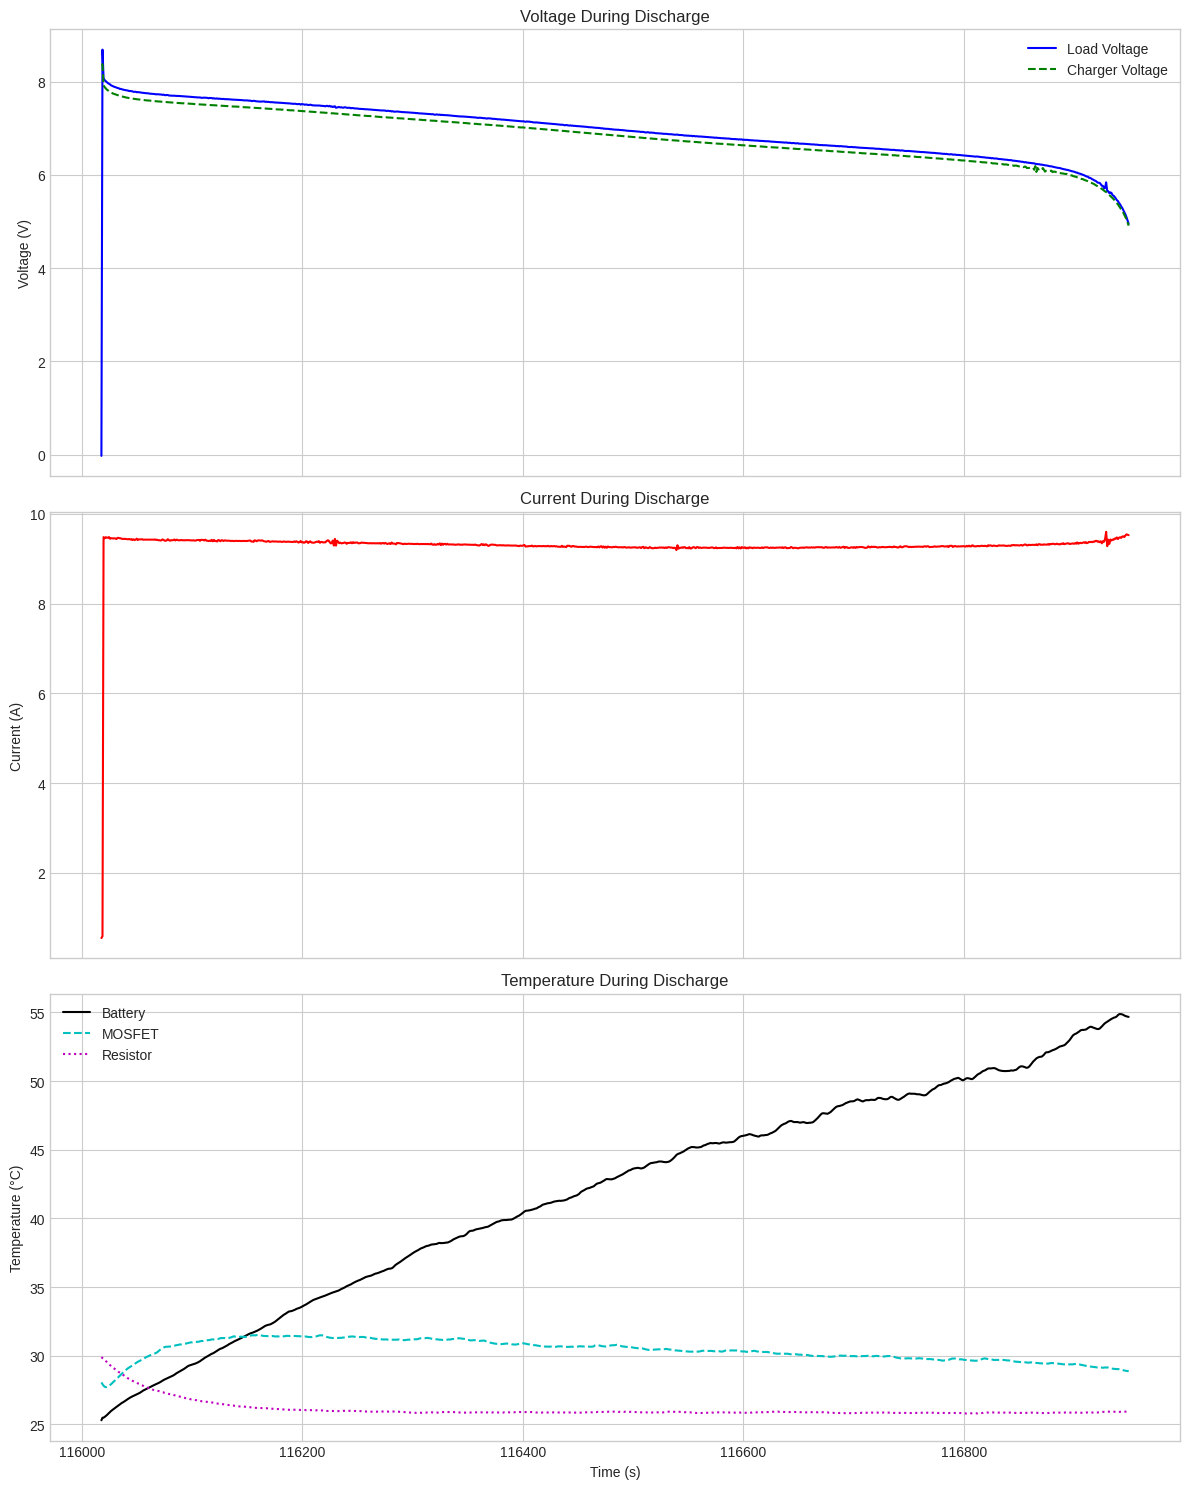

In [3]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0] if any(missing_values > 0) else "No missing values")

# Basic statistics
print("\nBasic statistics:")
df.describe()

# %% [markdown]
# Let's visualize the key measurements over time to better understand the discharge behavior.

# %%
# Plot voltage, current, and temperature over time
fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

# Voltage plot
axes[0].plot(df['time'], df['voltage_load'], 'b-', label='Load Voltage')
axes[0].plot(df['time'], df['voltage_charger'], 'g--', label='Charger Voltage')
axes[0].set_ylabel('Voltage (V)')
axes[0].set_title('Voltage During Discharge')
axes[0].legend()
axes[0].grid(True)

# Current plot
axes[1].plot(df['time'], df['current_load'], 'r-')
axes[1].set_ylabel('Current (A)')
axes[1].set_title('Current During Discharge')
axes[1].grid(True)

# Temperature plot
axes[2].plot(df['time'], df['temperature_battery'], 'k-', label='Battery')
axes[2].plot(df['time'], df['temperature_mosfet'], 'c--', label='MOSFET')
axes[2].plot(df['time'], df['temperature_resistor'], 'm:', label='Resistor')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Temperature (°C)')
axes[2].set_title('Temperature During Discharge')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


# 2. Implementing Different Windowing Strategies
Now let's implement several windowing strategies to evaluate their effectiveness.
We'll implement:
 
### 1. Fixed-size time windows
### 2. Fixed-size measurement windows
### 3. Percentage-based discharge windows
### 4. Overlapping windows

## 2.1 Fixed-size Time Windows
 
This strategy divides the discharge data into windows of equal time duration.

In [4]:
def create_time_windows(df, window_duration_seconds=60):
    """
    Create windows based on fixed time intervals.
    
    Args:
        df: Discharge dataframe
        window_duration_seconds: Window size in seconds
        
    Returns:
        List of dataframes, each representing a window
    """
    # Get the start and end time
    start_time = df['time'].min()
    end_time = df['time'].max()
    
    # Create time bins
    time_bins = np.arange(start_time, end_time + window_duration_seconds, window_duration_seconds)
    
    # Group data by time bins
    windows = []
    window_labels = []
    
    for i in range(len(time_bins) - 1):
        window_start = time_bins[i]
        window_end = time_bins[i+1]
        
        # Extract data within this time window
        window_data = df[(df['time'] >= window_start) & (df['time'] < window_end)]
        
        # Only add if window has data
        if not window_data.empty:
            windows.append(window_data)
            window_labels.append(f"Time Window {i+1}")
    
    return windows, window_labels

# Create time windows (60-second intervals)
time_windows, time_window_labels = create_time_windows(df, window_duration_seconds=60)

print(f"Created {len(time_windows)} time-based windows")
print(f"Sample sizes: {[len(window) for window in time_windows[:5]]} (first 5 windows)")

Created 8 time-based windows
Sample sizes: [61, 59, 60, 58, 60] (first 5 windows)


## 2.2 Fixed-size Measurement Windows

This strategy divides the discharge data into windows with a fixed number of measurements.

In [5]:
def create_measurement_windows(df, window_size=100, overlap=0):
    """
    Create windows with fixed number of measurements.
    
    Args:
        df: Discharge dataframe
        window_size: Number of measurements per window
        overlap: Number of overlapping measurements between windows
        
    Returns:
        List of dataframes, each representing a window
    """
    data_length = len(df)
    stride = window_size - overlap
    
    windows = []
    window_labels = []
    
    # Calculate number of windows
    num_windows = 1 + (data_length - window_size) // stride
    
    for i in range(num_windows):
        start_idx = i * stride
        end_idx = start_idx + window_size
        
        # Extract data for this window
        window_data = df.iloc[start_idx:end_idx].copy()
        
        # Only add if window has the right size
        if len(window_data) == window_size:
            windows.append(window_data)
            window_labels.append(f"Measurement Window {i+1}")
    
    return windows, window_labels

# Create measurement windows (100 measurements per window)
measurement_windows, measurement_window_labels = create_measurement_windows(df, window_size=100, overlap=0)

print(f"Created {len(measurement_windows)} measurement-based windows")
print(f"Sample sizes: {[len(window) for window in measurement_windows[:5]]} (first 5 windows)")

Created 4 measurement-based windows
Sample sizes: [100, 100, 100, 100] (first 5 windows)


## 2.3 Percentage-based Discharge Windows

This strategy divides the discharge data into windows representing equal portions of the discharge process

In [6]:
def create_percentage_windows(df, num_windows=4):
    """
    Create windows based on equal percentage segments of the discharge.
    
    Args:
        df: Discharge dataframe
        num_windows: Number of equal percentage windows to create
        
    Returns:
        List of dataframes, each representing a window
    """
    data_length = len(df)
    window_size = data_length // num_windows
    
    windows = []
    window_labels = []
    
    for i in range(num_windows):
        start_idx = i * window_size
        end_idx = start_idx + window_size if i < num_windows - 1 else data_length
        
        # Extract data for this window
        window_data = df.iloc[start_idx:end_idx].copy()
        
        windows.append(window_data)
        window_labels.append(f"{i*25}-{(i+1)*25}% Discharge")
    
    return windows, window_labels

# Create percentage-based windows (4 equal segments)
percentage_windows, percentage_window_labels = create_percentage_windows(df, num_windows=4)

print(f"Created {len(percentage_windows)} percentage-based windows")
print(f"Sample sizes: {[len(window) for window in percentage_windows]} (all windows)")

Created 4 percentage-based windows
Sample sizes: [113, 113, 113, 116] (all windows)


## 2.4 Overlapping Windows
 
This strategy creates overlapping windows to capture transitional behaviors.

In [7]:
def create_overlapping_windows(df, window_size=100, overlap_percentage=50):
    """
    Create overlapping windows with fixed number of measurements.
    
    Args:
        df: Discharge dataframe
        window_size: Number of measurements per window
        overlap_percentage: Percentage of overlap between consecutive windows
        
    Returns:
        List of dataframes, each representing a window
    """
    overlap = int(window_size * overlap_percentage / 100)
    return create_measurement_windows(df, window_size, overlap)

# Create overlapping windows (100 measurements per window, 50% overlap)
overlapping_windows, overlapping_window_labels = create_overlapping_windows(df, window_size=100, overlap_percentage=50)

print(f"Created {len(overlapping_windows)} overlapping windows")
print(f"Sample sizes: {[len(window) for window in overlapping_windows[:5]]} (first 5 windows)")


Created 8 overlapping windows
Sample sizes: [100, 100, 100, 100, 100] (first 5 windows)


# 3. Feature Extraction for Windows

Now let's implement feature extraction for each window. We'll calculate various statistical and derived features.

Window features overview:


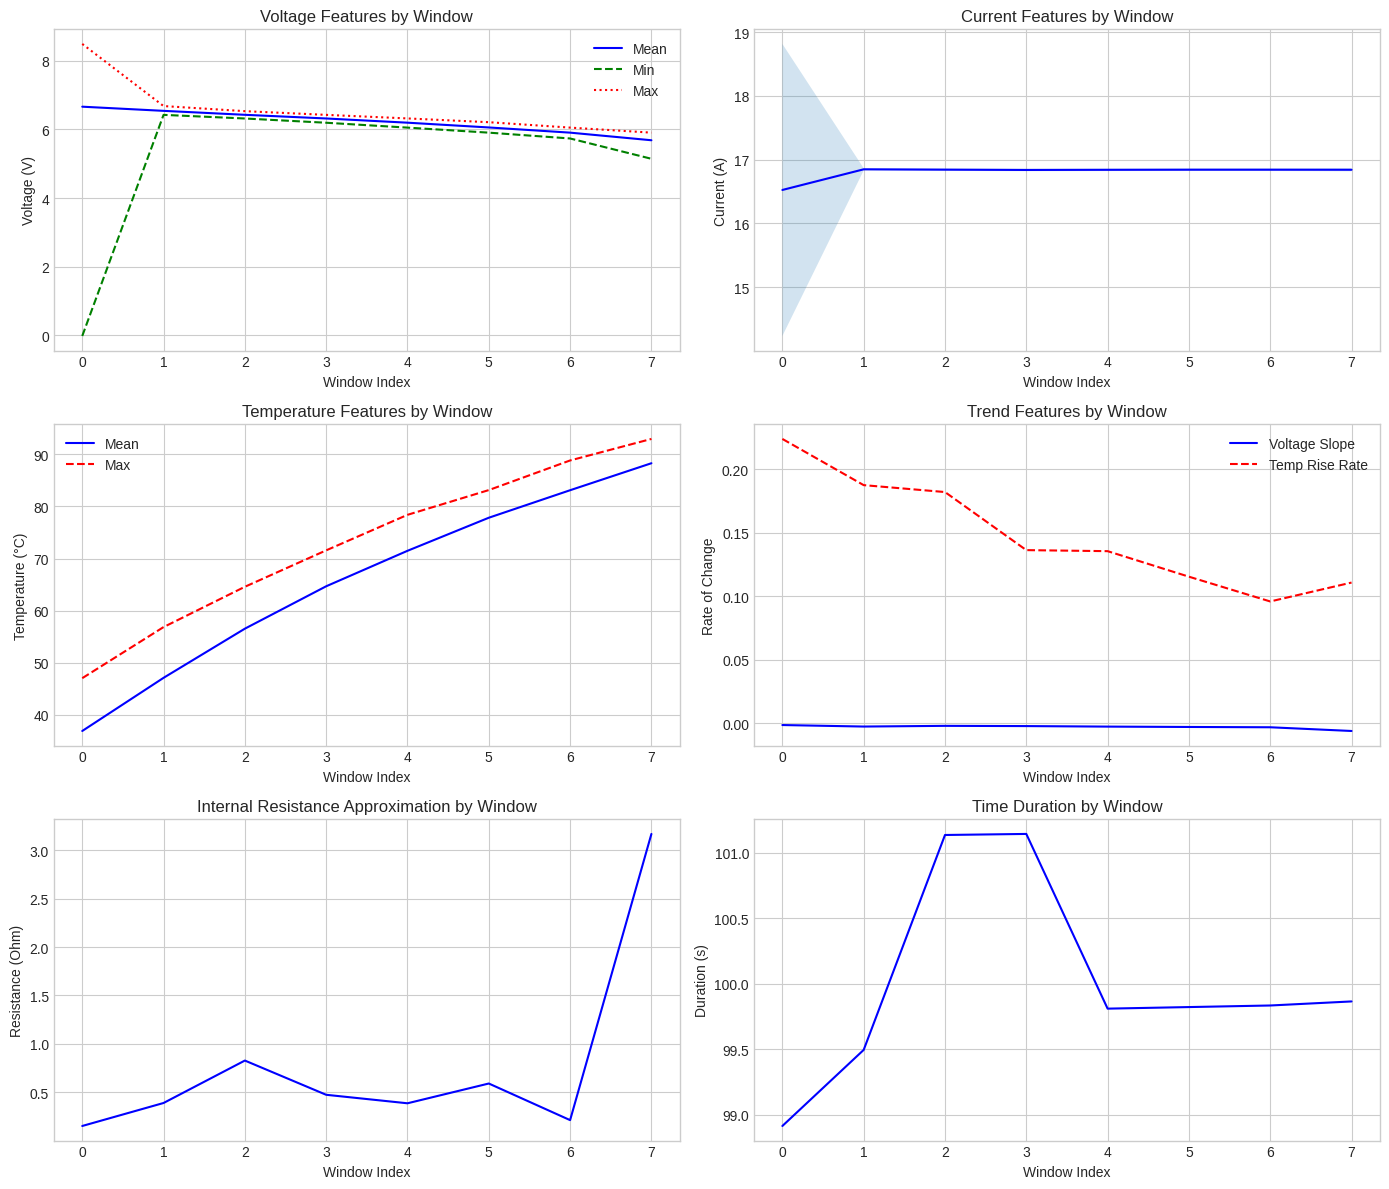

In [8]:
def calculate_window_features(window_df):
    """
    Calculate features for a window of discharge data.
    
    Args:
        window_df: DataFrame containing the window data
        
    Returns:
        Dictionary of features
    """
    # Statistical features from raw measurements
    features = {
        # Voltage features
        'voltage_load_mean': window_df['voltage_load'].mean(),
        'voltage_load_min': window_df['voltage_load'].min(),
        'voltage_load_max': window_df['voltage_load'].max(),
        'voltage_load_std': window_df['voltage_load'].std(),
        'voltage_load_range': window_df['voltage_load'].max() - window_df['voltage_load'].min(),
        
        # Current features
        'current_load_mean': window_df['current_load'].mean(),
        'current_load_std': window_df['current_load'].std(),
        
        # Temperature features
        'temperature_battery_mean': window_df['temperature_battery'].mean(),
        'temperature_battery_max': window_df['temperature_battery'].max(),
        'temperature_battery_range': window_df['temperature_battery'].max() - window_df['temperature_battery'].min(),
        
        # Time features
        'time_duration': window_df['time'].max() - window_df['time'].min(),
        
        # Count features
        'measurement_count': len(window_df)
    }
    
    # Trend features (slope of key parameters)
    if len(window_df) > 1:
        # Calculate voltage slope (V/s)
        time_vals = window_df['time'].values
        voltage_vals = window_df['voltage_load'].values
        voltage_slope, _ = np.polyfit(time_vals, voltage_vals, 1)
        features['voltage_slope'] = voltage_slope
        
        # Calculate temperature rise rate (°C/s)
        temp_vals = window_df['temperature_battery'].values
        temp_slope, _ = np.polyfit(time_vals, temp_vals, 1)
        features['temperature_rise_rate'] = temp_slope
    else:
        features['voltage_slope'] = 0
        features['temperature_rise_rate'] = 0
    
    # Derived features
    # Calculate approximate internal resistance (using Ohm's law)
    if window_df['current_load'].std() > 0:  # Only if current varies
        # Simple V/I approximation
        features['internal_resistance_approx'] = abs(
            np.corrcoef(window_df['voltage_load'], window_df['current_load'])[0, 1] * 
            window_df['voltage_load'].std() / window_df['current_load'].std()
        )
    else:
        features['internal_resistance_approx'] = np.nan
    
    return features

# Apply feature extraction to one of our windowing strategies
# Let's use overlapping windows as an example
window_features = []

for i, window in enumerate(overlapping_windows):
    features = calculate_window_features(window)
    features['window_index'] = i  # Add window index
    window_features.append(features)

# Convert to DataFrame
window_features_df = pd.DataFrame(window_features)
print("Window features overview:")
window_features_df.head()

# %% [markdown]
# Let's visualize some of these window-level features to see how they evolve over the discharge.

# %%
# Plot window-level features
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Voltage features
axes[0, 0].plot(window_features_df['window_index'], window_features_df['voltage_load_mean'], 'b-', label='Mean')
axes[0, 0].plot(window_features_df['window_index'], window_features_df['voltage_load_min'], 'g--', label='Min')
axes[0, 0].plot(window_features_df['window_index'], window_features_df['voltage_load_max'], 'r:', label='Max')
axes[0, 0].set_title('Voltage Features by Window')
axes[0, 0].set_ylabel('Voltage (V)')
axes[0, 0].legend()

# Current features
axes[0, 1].plot(window_features_df['window_index'], window_features_df['current_load_mean'], 'b-')
axes[0, 1].fill_between(
    window_features_df['window_index'],
    window_features_df['current_load_mean'] - window_features_df['current_load_std'],
    window_features_df['current_load_mean'] + window_features_df['current_load_std'],
    alpha=0.2
)
axes[0, 1].set_title('Current Features by Window')
axes[0, 1].set_ylabel('Current (A)')

# Temperature features
axes[1, 0].plot(window_features_df['window_index'], window_features_df['temperature_battery_mean'], 'b-', label='Mean')
axes[1, 0].plot(window_features_df['window_index'], window_features_df['temperature_battery_max'], 'r--', label='Max')
axes[1, 0].set_title('Temperature Features by Window')
axes[1, 0].set_ylabel('Temperature (°C)')
axes[1, 0].legend()

# Trends and slopes
axes[1, 1].plot(window_features_df['window_index'], window_features_df['voltage_slope'], 'b-', label='Voltage Slope')
axes[1, 1].plot(window_features_df['window_index'], window_features_df['temperature_rise_rate'], 'r--', label='Temp Rise Rate')
axes[1, 1].set_title('Trend Features by Window')
axes[1, 1].set_ylabel('Rate of Change')
axes[1, 1].legend()

# Internal resistance and time duration
axes[2, 0].plot(window_features_df['window_index'], window_features_df['internal_resistance_approx'], 'b-')
axes[2, 0].set_title('Internal Resistance Approximation by Window')
axes[2, 0].set_ylabel('Resistance (Ohm)')

axes[2, 1].plot(window_features_df['window_index'], window_features_df['time_duration'], 'b-')
axes[2, 1].set_title('Time Duration by Window')
axes[2, 1].set_ylabel('Duration (s)')

for ax in axes.flatten():
    ax.set_xlabel('Window Index')
    ax.grid(True)

plt.tight_layout()
plt.show()

## 4. Visualizing Windows on Original Data

Let's now visualize how different windowing strategies divide the original data, to better understand their characteristics.

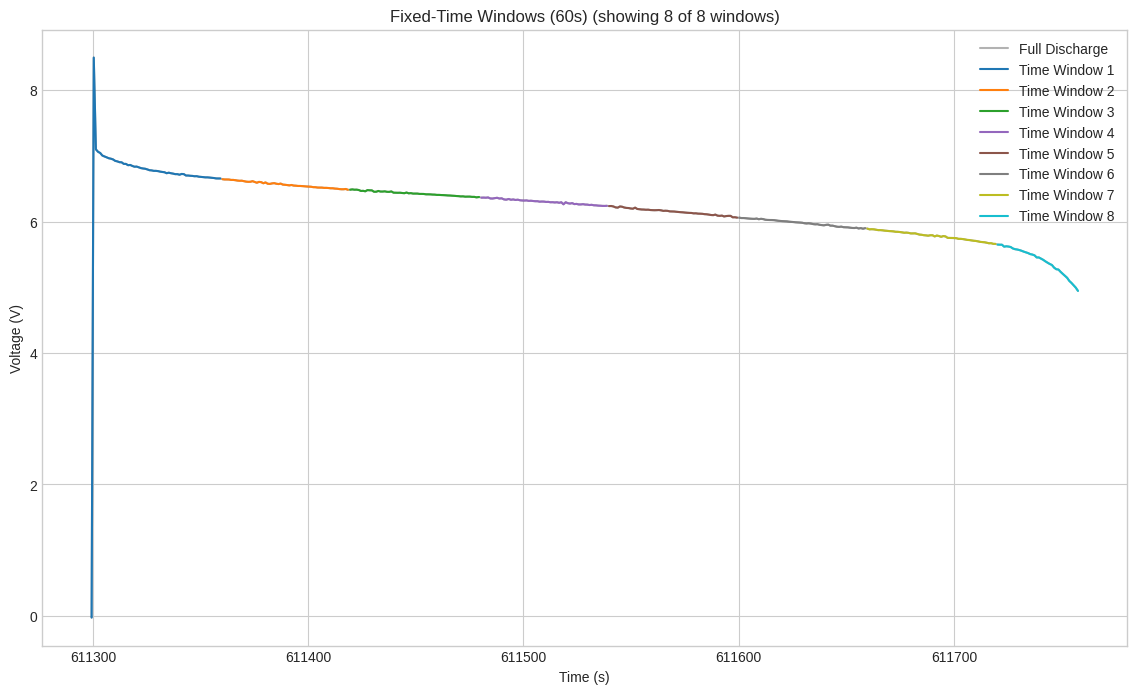

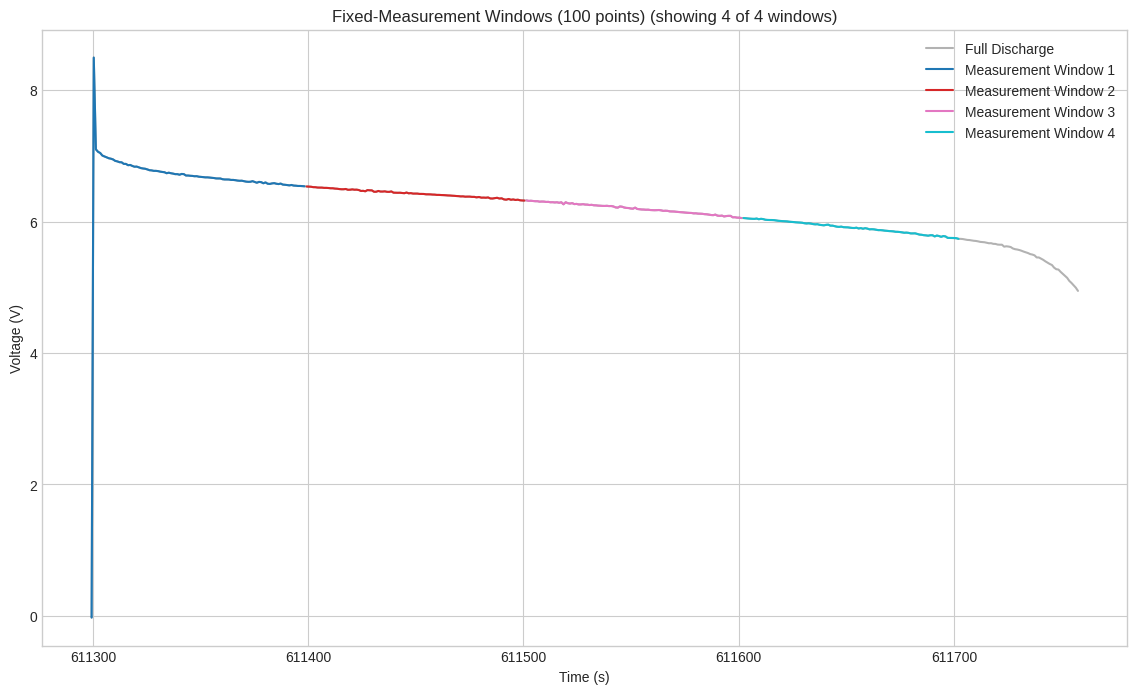

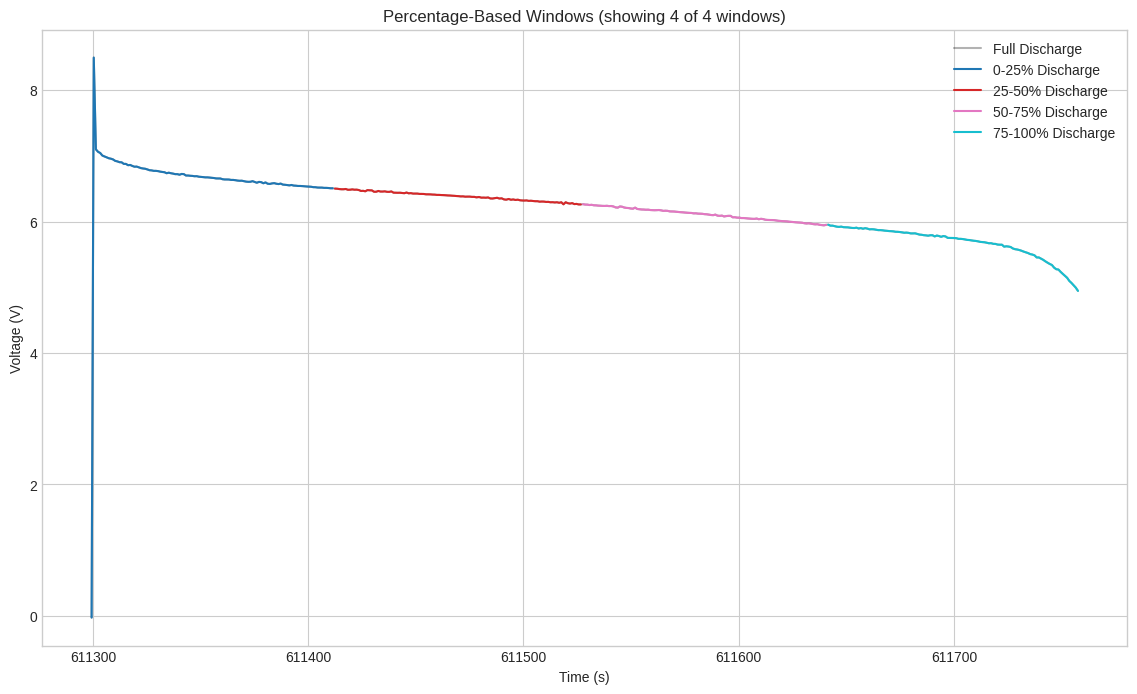

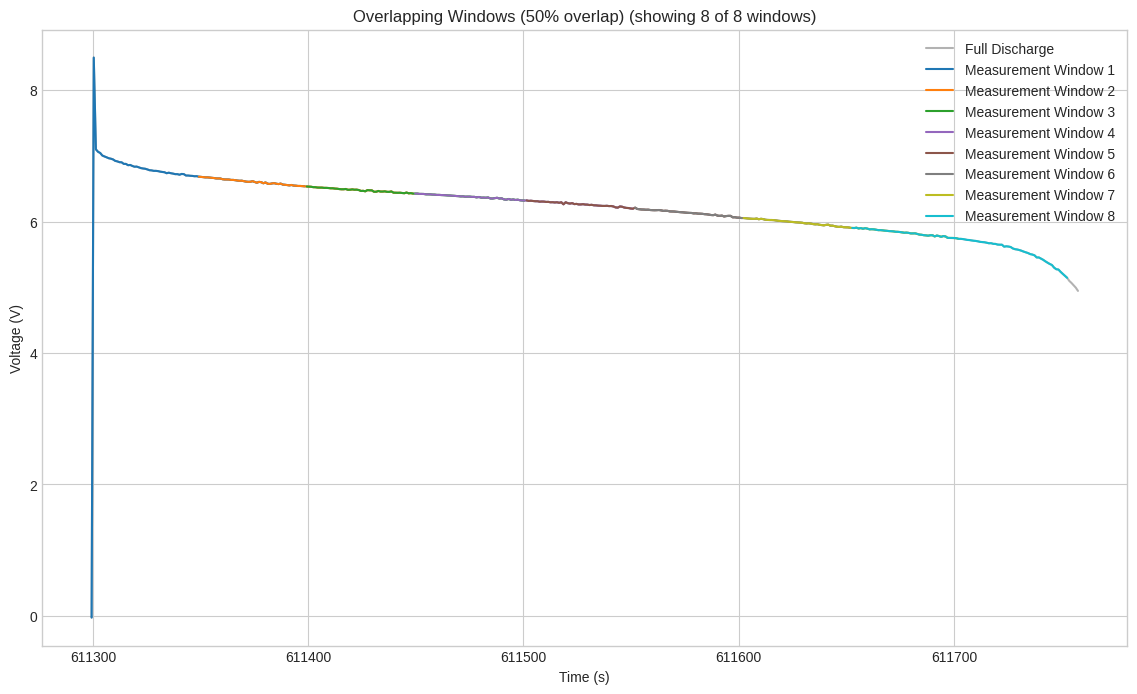

In [9]:
def plot_windows_on_data(df, windows, window_labels, title, max_windows=10):
    """
    Plot how windows divide the original data.
    
    Args:
        df: Original dataframe
        windows: List of window dataframes
        window_labels: Labels for each window
        title: Plot title
        max_windows: Maximum number of windows to plot (for clarity)
    """
    # Plot voltage over time
    plt.figure(figsize=(14, 8))
    
    # Plot the full discharge voltage
    plt.plot(df['time'], df['voltage_load'], 'k-', alpha=0.3, label='Full Discharge')
    
    # Plot each window with a different color
    colors = plt.cm.tab10(np.linspace(0, 1, min(len(windows), max_windows)))
    
    for i, (window, label) in enumerate(zip(windows, window_labels)):
        if i >= max_windows:
            break
        plt.plot(window['time'], window['voltage_load'], color=colors[i], label=label)
    
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.title(f'{title} (showing {min(len(windows), max_windows)} of {len(windows)} windows)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot each windowing strategy
plot_windows_on_data(df, time_windows, time_window_labels, 'Fixed-Time Windows (60s)')
plot_windows_on_data(df, measurement_windows, measurement_window_labels, 'Fixed-Measurement Windows (100 points)')
plot_windows_on_data(df, percentage_windows, percentage_window_labels, 'Percentage-Based Windows')
plot_windows_on_data(df, overlapping_windows, overlapping_window_labels, 'Overlapping Windows (50% overlap)')

## 5. Comparing Window Sizes and Overlap Effects

Let's explore how window size and overlap percentage affect the number of windows and feature extraction.

In [10]:
def evaluate_window_parameters(df, window_sizes, overlap_percentages):
    """
    Evaluate different window sizes and overlap percentages.
    
    Args:
        df: Discharge dataframe
        window_sizes: List of window sizes to test
        overlap_percentages: List of overlap percentages to test
    """
    results = []
    
    for window_size in window_sizes:
        for overlap_pct in overlap_percentages:
            # Create overlapping windows
            windows, _ = create_overlapping_windows(df, window_size, overlap_pct)
            
            # Calculate features for each window
            feature_variation = []
            for window in windows:
                features = calculate_window_features(window)
                feature_variation.append(features['voltage_load_mean'])
            
            # Record results
            results.append({
                'window_size': window_size,
                'overlap_percentage': overlap_pct,
                'num_windows': len(windows),
                'feature_variation': np.std(feature_variation) if feature_variation else 0
            })
    
    return pd.DataFrame(results)

# Test different window parameters
window_sizes = [50, 100, 200, 300]
overlap_percentages = [0, 25, 50, 75]

parameter_results = evaluate_window_parameters(df, window_sizes, overlap_percentages)
print("Window parameter evaluation:")
parameter_results

Window parameter evaluation:


,window_size,overlap_percentage,num_windows,feature_variation
0,50,0,9,0.360766
1,50,25,11,0.312794
2,50,50,17,0.335226
3,50,75,32,0.329535
4,100,0,4,0.280204
5,100,25,5,0.264542
6,100,50,8,0.309382
7,100,75,15,0.287283
8,200,0,2,0.246870
9,200,25,2,0.178328


## Let's visualize these results to understand the trade-offs.


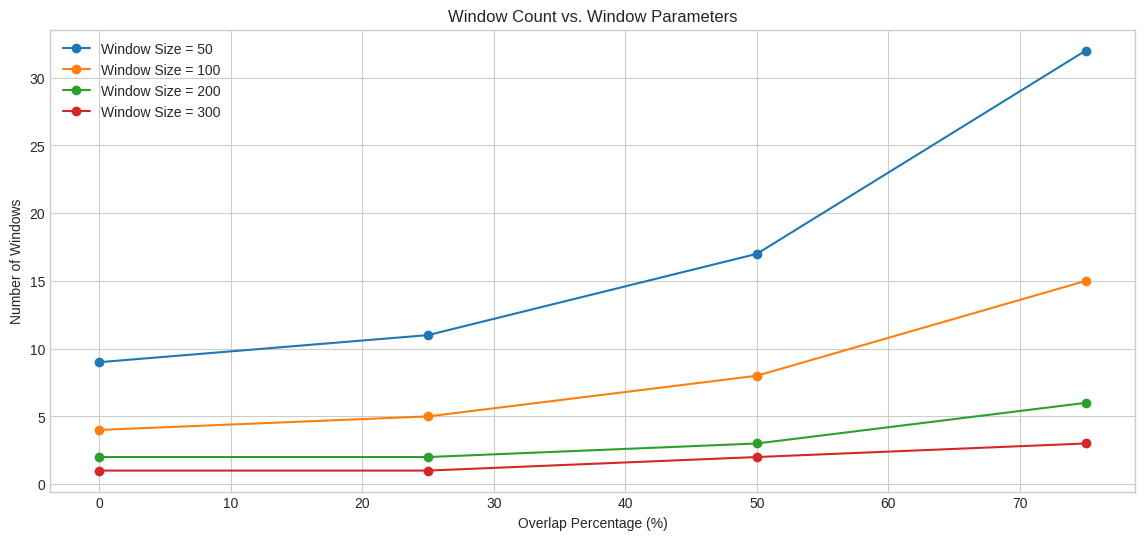

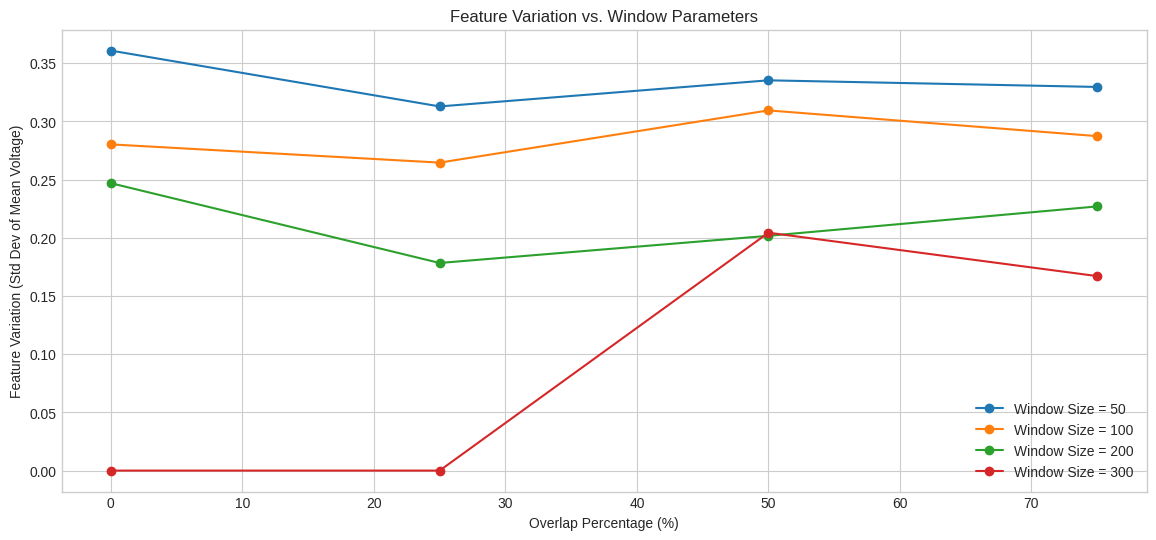

In [11]:
# Plot window count vs parameters
plt.figure(figsize=(14, 6))

# Group by window size
for window_size in window_sizes:
    subset = parameter_results[parameter_results['window_size'] == window_size]
    plt.plot(subset['overlap_percentage'], subset['num_windows'], 'o-', 
             label=f'Window Size = {window_size}')

plt.xlabel('Overlap Percentage (%)')
plt.ylabel('Number of Windows')
plt.title('Window Count vs. Window Parameters')
plt.legend()
plt.grid(True)
plt.show()

# Plot feature variation vs parameters
plt.figure(figsize=(14, 6))

for window_size in window_sizes:
    subset = parameter_results[parameter_results['window_size'] == window_size]
    plt.plot(subset['overlap_percentage'], subset['feature_variation'], 'o-', 
             label=f'Window Size = {window_size}')

plt.xlabel('Overlap Percentage (%)')
plt.ylabel('Feature Variation (Std Dev of Mean Voltage)')
plt.title('Feature Variation vs. Window Parameters')
plt.legend()
plt.grid(True)
plt.show()

## 6. Preparing Data for Machine Learning

Now let's demonstrate how to prepare the windowed data for a machine learning model like LSTM.

In [12]:
def prepare_windows_for_ml(windows, feature_names=None):
    """
    Convert windows to a format suitable for ML models like LSTM.
    
    Args:
        windows: List of window dataframes
        feature_names: List of column names to include as features
        
    Returns:
        X: 3D array with shape (num_windows, window_size, num_features)
    """
    if not windows:
        return None
    
    # If feature_names not provided, use numerical columns
    if feature_names is None:
        feature_names = [col for col in windows[0].columns if windows[0][col].dtype in [np.float64, np.int64]]
    
    # Find the minimum window size (to handle variable-sized windows)
    min_window_size = min(len(window) for window in windows)
    
    # Initialize the 3D array
    X = np.zeros((len(windows), min_window_size, len(feature_names)))
    
    # Fill the array with data
    for i, window in enumerate(windows):
        for j, feature in enumerate(feature_names):
            X[i, :, j] = window[feature].values[:min_window_size]
    
    return X

# Define features to use
ml_features = ['voltage_load', 'current_load', 'temperature_battery']

# Prepare data for ML (using overlapping windows as an example)
X = prepare_windows_for_ml(overlapping_windows, ml_features)

print(f"ML-ready data shape: {X.shape}")
print(f"This represents: {X.shape[0]} windows × {X.shape[1]} time steps × {X.shape[2]} features")


ML-ready data shape: (8, 100, 3)
This represents: 8 windows × 100 time steps × 3 features


## Let's visualize one sample from the prepared ML data to confirm it's formatted correctly.

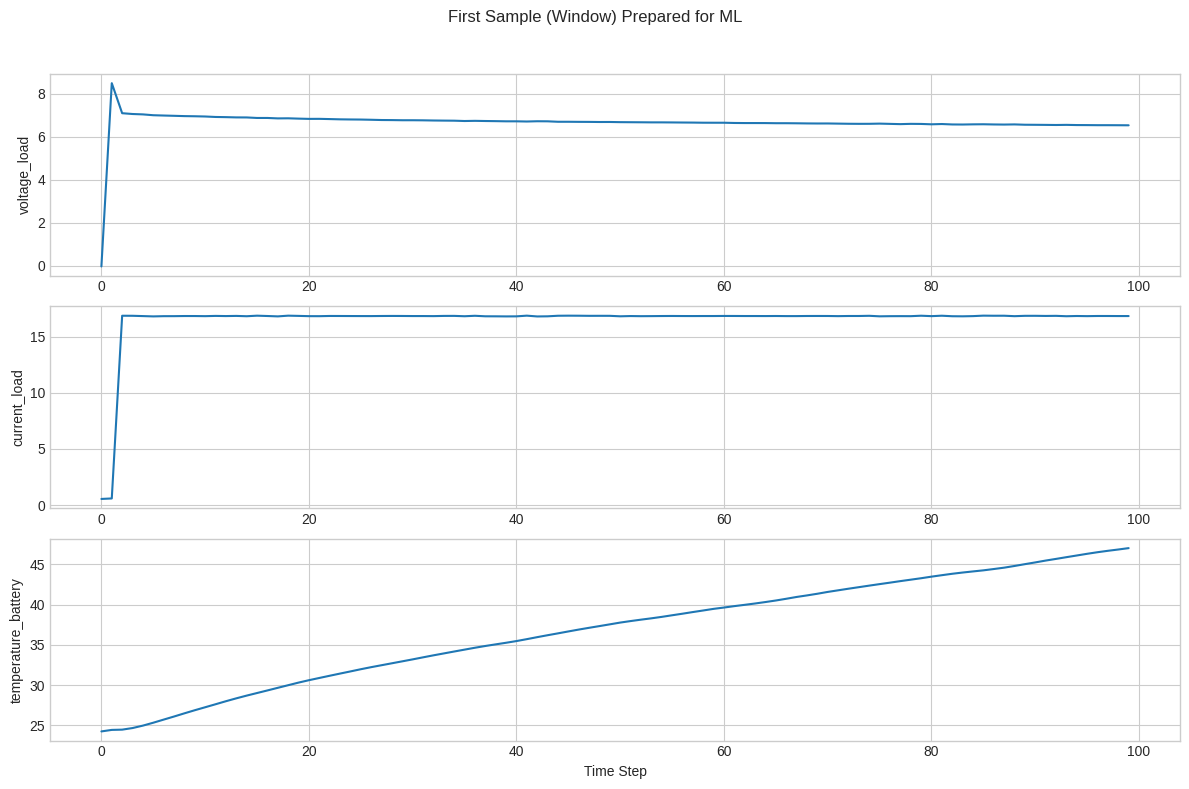

In [13]:
# Visualize the first sample (window)
plt.figure(figsize=(12, 8))

# Plot each feature
for i, feature in enumerate(ml_features):
    plt.subplot(len(ml_features), 1, i+1)
    plt.plot(X[0, :, i])
    plt.ylabel(feature)
    plt.grid(True)
    
plt.xlabel('Time Step')
plt.tight_layout()
plt.suptitle('First Sample (Window) Prepared for ML')
plt.subplots_adjust(top=0.9)
plt.show()

## 7. Processing Multiple Discharge Cycles

Finally, let's implement a function to process multiple discharge cycles with our windowing approach.

In [14]:
def process_discharge_folder(folder_path, window_size=100, overlap_percentage=50, 
                             features_to_extract=None, reference_only=False, regular_only=False):
    """
    Process all discharge files in a folder with the windowing approach.
    
    Args:
        folder_path: Path to the folder containing discharge files
        window_size: Size of each window
        overlap_percentage: Overlap percentage between windows
        features_to_extract: List of features to extract for ML
        reference_only: If True, process only reference discharges
        regular_only: If True, process only regular discharges
        
    Returns:
        X: 3D array of windowed data
        cycle_info: DataFrame with information about each cycle
    """
    if features_to_extract is None:
        features_to_extract = ['voltage_load', 'current_load', 'temperature_battery']
    
    # Find all discharge files
    discharge_files = glob(os.path.join(folder_path, "discharge*.csv"))
    
    # Filter files if needed
    if reference_only:
        discharge_files = [f for f in discharge_files if "reference" in f]
    elif regular_only:
        discharge_files = [f for f in discharge_files if "reference" not in f]
    
    print(f"Processing {len(discharge_files)} discharge files")
    
    all_windows = []
    cycle_info = []
    
    for file in discharge_files:
        try:
            # Extract cycle number and type
            filename = os.path.basename(file)
            cycle_num = int(filename.replace("discharge", "").replace("_reference", "").replace(".csv", ""))
            is_reference = "reference" in filename
            
            # Load the data
            df = pd.read_csv(file)
            
            # Create windows
            windows, _ = create_overlapping_windows(df, window_size, overlap_percentage)
            
            # Prepare windows for ML
            X_cycle = prepare_windows_for_ml(windows, features_to_extract)
            
            if X_cycle is not None and X_cycle.shape[0] > 0:
                # Add to the collection
                all_windows.append(X_cycle)
                
                # Add cycle info
                cycle_info.append({
                    'file': filename,
                    'cycle_number': cycle_num,
                    'is_reference': is_reference,
                    'num_windows': X_cycle.shape[0],
                    'duration': df['time'].max() - df['time'].min(),
                    'mean_voltage': df['voltage_load'].mean(),
                    'mean_current': df['current_load'].mean(),
                    'max_temperature': df['temperature_battery'].max()
                })
        except Exception as e:
            print(f"Error processing {file}: {str(e)}")
    
    # Combine all windows
    if all_windows:
        X = np.vstack(all_windows)
        cycle_info_df = pd.DataFrame(cycle_info)
        return X, cycle_info_df
    else:
        return None, pd.DataFrame(cycle_info)

# Example usage (commented out to avoid execution)
# Let's just demonstrate the function's signature
print("To process multiple discharge cycles, you would use:")
print("X, cycle_info = process_discharge_folder('path/to/discharge/folder', window_size=100, overlap_percentage=50)")
print("This would generate a 3D array X with shape (total_windows, time_steps, features)")

To process multiple discharge cycles, you would use:
X, cycle_info = process_discharge_folder('path/to/discharge/folder', window_size=100, overlap_percentage=50)
This would generate a 3D array X with shape (total_windows, time_steps, features)


## 8. Conclusion and Recommendations

Based on our analysis, here are the recommendations for windowing your battery discharge data:

1. **Window Size**: Use windows of 100-200 measurements. This provides enough data for meaningful feature extraction while maintaining temporal resolution.

2. **Overlap**: Use 50% overlap between windows. This creates more training data and helps capture transitional behavior.

3. **Features**: Extract both statistical features (mean, min, max, etc.) and derived features (slopes, internal resistance) from each window.

4. **Normalization**: Consider normalizing features within each discharge cycle to account for different discharge conditions.

5. **Labeling Strategy**: For predictive maintenance, each window should be labeled with:
   - Remaining useful life (number of cycles until failure)
   - Battery health state (good, degrading, near failure)
   - Regression target (capacity fade percentage)